# **Preprocessing**

https://archive.ics.uci.edu/dataset/791/metropt+3+dataset

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv('data/metropt3_dataset/MetroPT3(AirCompressor).csv')
df.head()

,Unnamed: 0,timestamp,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Motor_current,COMP,DV_eletric,Towers,MPG,LPS,Pressure_switch,Oil_level,Caudal_impulses
0,0,2020-02-01 00:00:00,-0.012,9.358,9.340,-0.024,9.358,53.600,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
1,10,2020-02-01 00:00:10,-0.014,9.348,9.332,-0.022,9.348,53.675,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
2,20,2020-02-01 00:00:19,-0.012,9.338,9.322,-0.022,9.338,53.600,0.0425,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
3,30,2020-02-01 00:00:29,-0.012,9.328,9.312,-0.022,9.328,53.425,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
4,40,2020-02-01 00:00:39,-0.012,9.318,9.302,-0.022,9.318,53.475,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0


## **1. Motor_Current Visualization**

Text(0, 0.5, 'Motor_current')

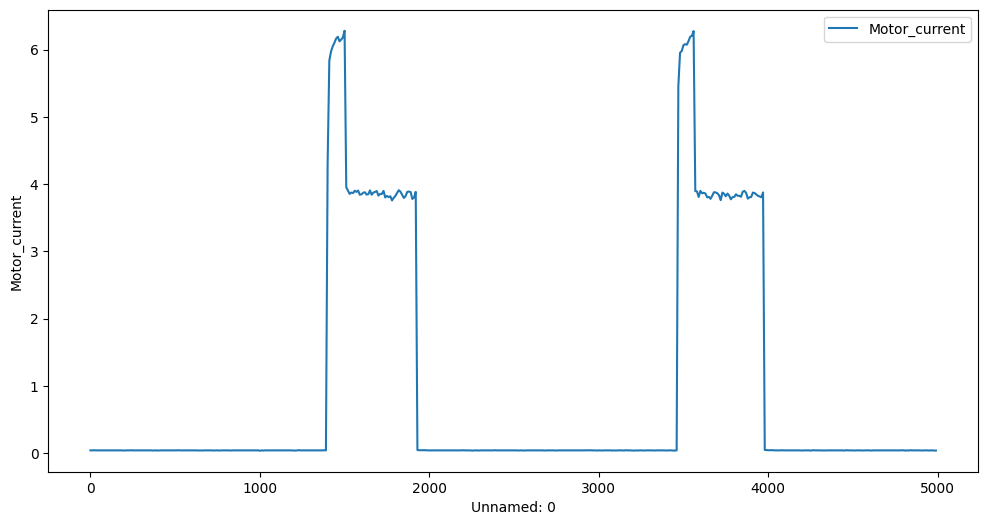

In [31]:
ax = df[:500].plot(x='Unnamed: 0', y='Motor_current', legend=True, figsize=(12, 6))
ax.set_xlabel('Unnamed: 0')
ax.set_ylabel('Motor_current')

## **2. Multivariate variables**

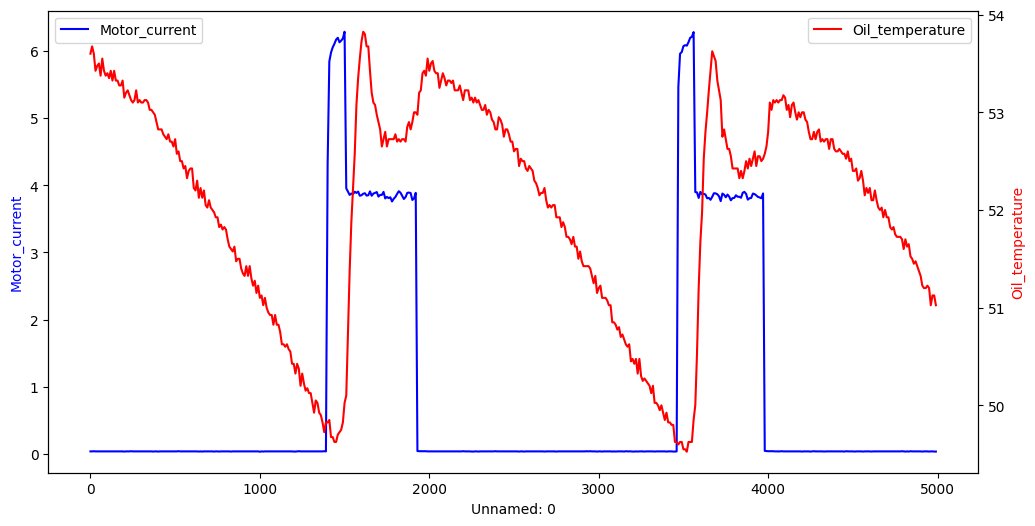

In [32]:
fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()

df_sub = df[:500]
p1, = ax1.plot(df_sub['Unnamed: 0'], df_sub['Motor_current'], color='blue', label='Motor_current')
p2, = ax2.plot(df_sub['Unnamed: 0'], df_sub['Oil_temperature'], color='red', label='Oil_temperature')

ax1.set_xlabel('Unnamed: 0')
ax1.set_ylabel('Motor_current', color='blue')
ax2.set_ylabel('Oil_temperature', color='red')

ax1.legend(handles=[p1], loc='upper left')
ax2.legend(handles=[p2], loc='upper right')

plt.show()

## **3. Correlation matrix**

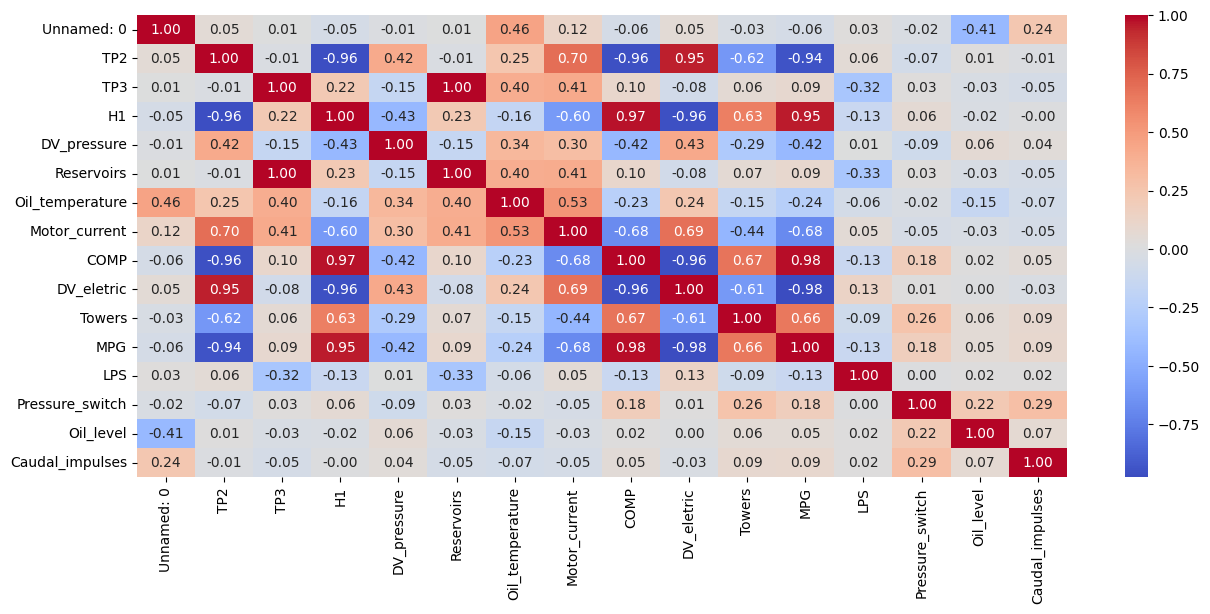

In [33]:
# Correlation matrix
df_sub = df.copy()
df_sub.drop('timestamp', axis=1, inplace=True)
plt.figure(figsize=(15, 6))
sns.heatmap(df_sub.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.show()

## **4. Visualization zoo**

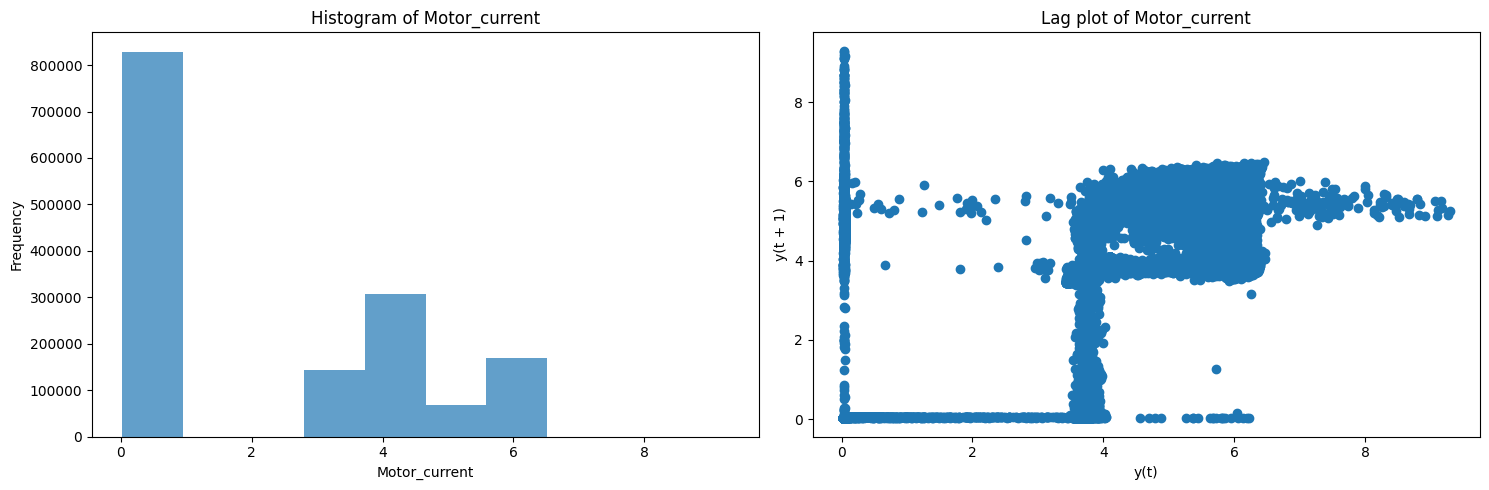

In [ ]:
plt.figure(figsize=(15, 5))
n_rows, n_cols = 1, 2

plt.subplot(n_rows, n_cols, 1)
plt.hist(df['Motor_current'], alpha=0.7)
plt.xlabel('Motor_current')
plt.ylabel('Frequency')
plt.title('Histogram of Motor_current')

plt.subplot(n_rows, n_cols, 2)
# lag plot of Motor_current
pd.plotting.lag_plot(df['Motor_current'])
plt.title('Lag plot of Motor_current')

plt.tight_layout()
plt.show()

### Rolling Window

## **5. Impute missing values**

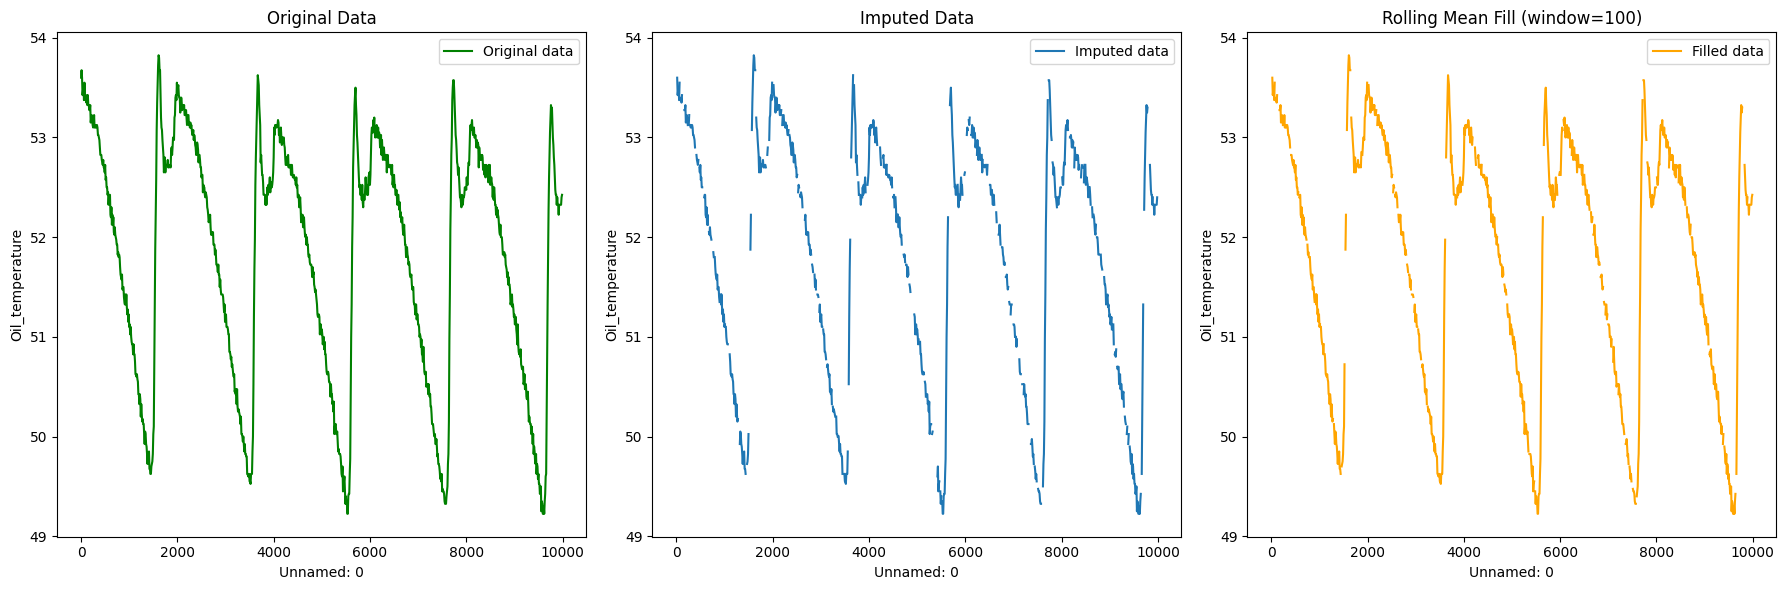

In [93]:
df_copy = df.copy()
mask_dataframe = df_copy.mask(np.random.random(df_copy.shape) < 0.1, other=pd.NA)
filled = mask_dataframe.copy()
filled['Unnamed: 0'] = df_copy['Unnamed: 0']
filled['Oil_temperature'] = filled['Oil_temperature'].fillna(filled['Oil_temperature'].rolling(window=100).mean())

plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.plot(df_copy['Unnamed: 0'][:1000], df_copy['Oil_temperature'][:1000], label='Original data', color='green')
plt.xlabel('Unnamed: 0')
plt.ylabel('Oil_temperature')
plt.title('Original Data')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(mask_dataframe['Unnamed: 0'][:1000], mask_dataframe['Oil_temperature'][:1000], label='Imputed data')
plt.xlabel('Unnamed: 0')
plt.ylabel('Oil_temperature')
plt.title('Imputed Data')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(filled['Unnamed: 0'][:1000], filled['Oil_temperature'][:1000], label='Filled data', color='orange')
plt.xlabel('Unnamed: 0')
plt.ylabel('Oil_temperature')
plt.title('Rolling Mean Fill (window=100)')
plt.legend()

plt.tight_layout()
plt.show()

## **5. bla**